In [1]:
from download_day import download_day
from load_saved_fd4 import load_saved_fd4
from scrape_aircraft_list import scrape_aircraft_list
from get_perf_model_typecodes import get_perf_model_typecodes 
from match_icao_model import match_icao_model
from process_airport_list import process_airport_list
from generate_flightpath import generate_flightpath
from plot_flightpaths import plot_flightpaths
from get_engine_data import get_engine_data
from perf_model_powerplant_parser import perf_model_powerplant_parser
from match_engine_to_emissions_db import match_engine_to_emissions_db
from process_month_emissions import process_month_emissions
from get_era5_wind import get_era5_wind
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import tqdm
from time import sleep
from geopy import distance
import requests
from icet import icet
from bffm2 import bffm2
import multiprocessing
from functools import partial
import zipfile
import shutil
import xarray as xr
import netCDF4
%matplotlib inline

# User Inputs:
start_time_str       = '2023-01-01T00:00:00Z'
stop_time_str        = '2023-12-31T23:59:59Z'
query_limit          = 15e4
send_notification    = True
make_plot            = True
output_dir           = "/scratch/omg28/Data/"

# Convert start and stop times to datetime objects
start_time_simple = pd.to_datetime(start_time_str).strftime("%Y-%m-%d")
stop_time_simple = pd.to_datetime(stop_time_str).strftime("%Y-%m-%d")
analysis_year = pd.to_datetime(start_time_str).year

# Define grid
lat_bins = np.arange(-90, 90.1, 0.5)
lon_bins = np.arange(-180, 180.1, 0.5)
alt_bins_ft = np.arange(0, 55001, 1000)
alt_bins_m = alt_bins_ft * 0.3048
nlat, nlon, nalt = len(lat_bins)-1, len(lon_bins)-1, len(alt_bins_m)-1

# Define countries whose airspace we want to exclude
conflict_countries = ['Russia', 'Ukraine', 'Libya', 'Syria', 'Sudan', 'Yemen']

## scale emissions files to be close to the right order of magnitude with respect to GAIA emissions.
# load in the netCDF file with the GAIA emissions data
gaia_file = f"/scratch/omg28/Data/GAIA/2019-01-monthly.nc"
gaia = xr.open_dataset(gaia_file).load()
print(gaia)

print("----------------------------------")

NOx_file = f"/scratch/omg28/Data/emissions/2023-02-01_to_2023-02-28_NOx_war_1deg.nc"
nox = xr.open_dataset(NOx_file).load()
print(nox)

<xarray.Dataset> Size: 181MB
Dimensions:        (longitude: 360, latitude: 180, altitude_ft: 50, time: 1)
Coordinates:
  * longitude      (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude       (latitude) float64 1kB -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * altitude_ft    (altitude_ft) float64 400B 500.0 1.5e+03 ... 4.95e+04
  * time           (time) datetime64[ns] 8B 2019-01-31
Data variables:
    seg_length_km  (longitude, latitude, altitude_ft, time) float64 26MB 0.0 ...
    fuel_burn      (longitude, latitude, altitude_ft, time) float64 26MB 0.0 ...
    nox            (longitude, latitude, altitude_ft, time) float64 26MB 0.0 ...
    co             (longitude, latitude, altitude_ft, time) float64 26MB 0.0 ...
    hc             (longitude, latitude, altitude_ft, time) float64 26MB 0.0 ...
    nvpm_mass      (longitude, latitude, altitude_ft, time) float64 26MB 0.0 ...
    nvpm_number    (longitude, latitude, altitude_ft, time) float64 26MB 0.0 ...
-----------

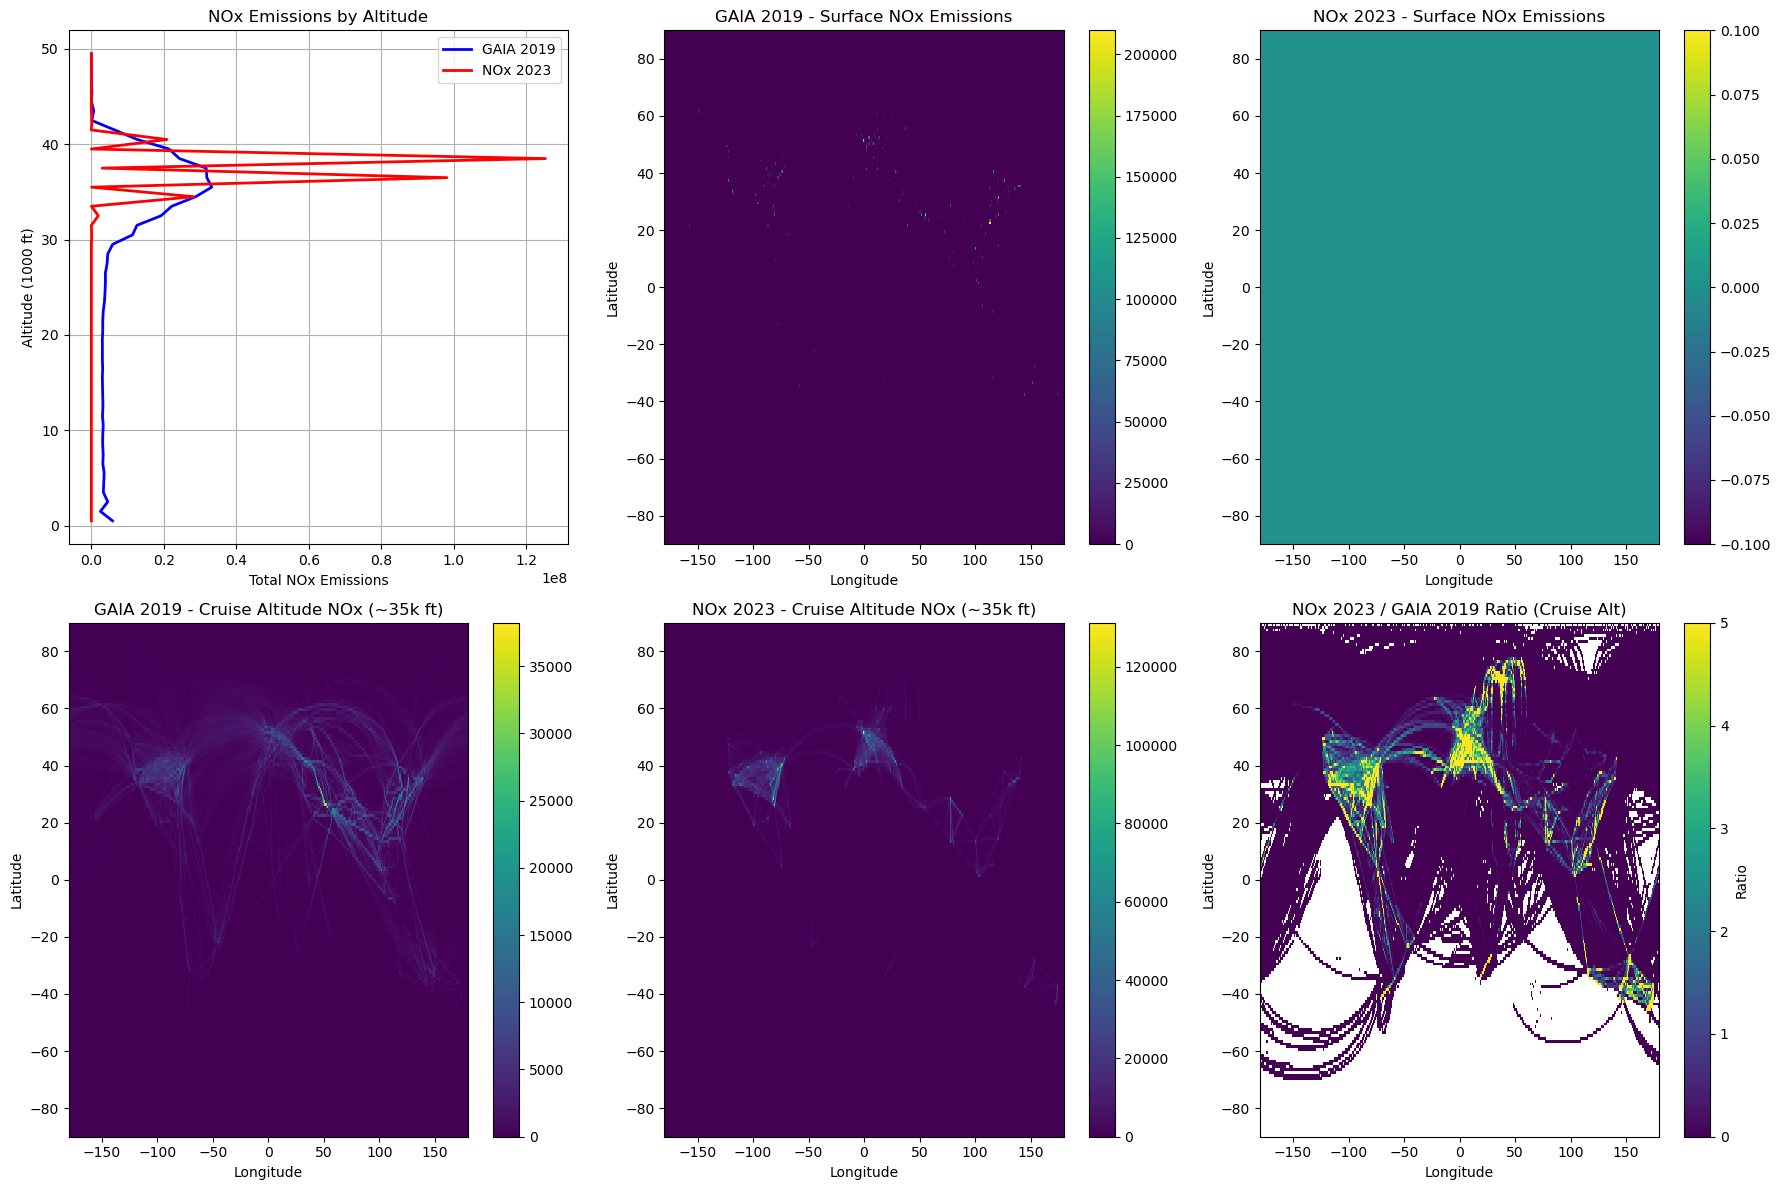

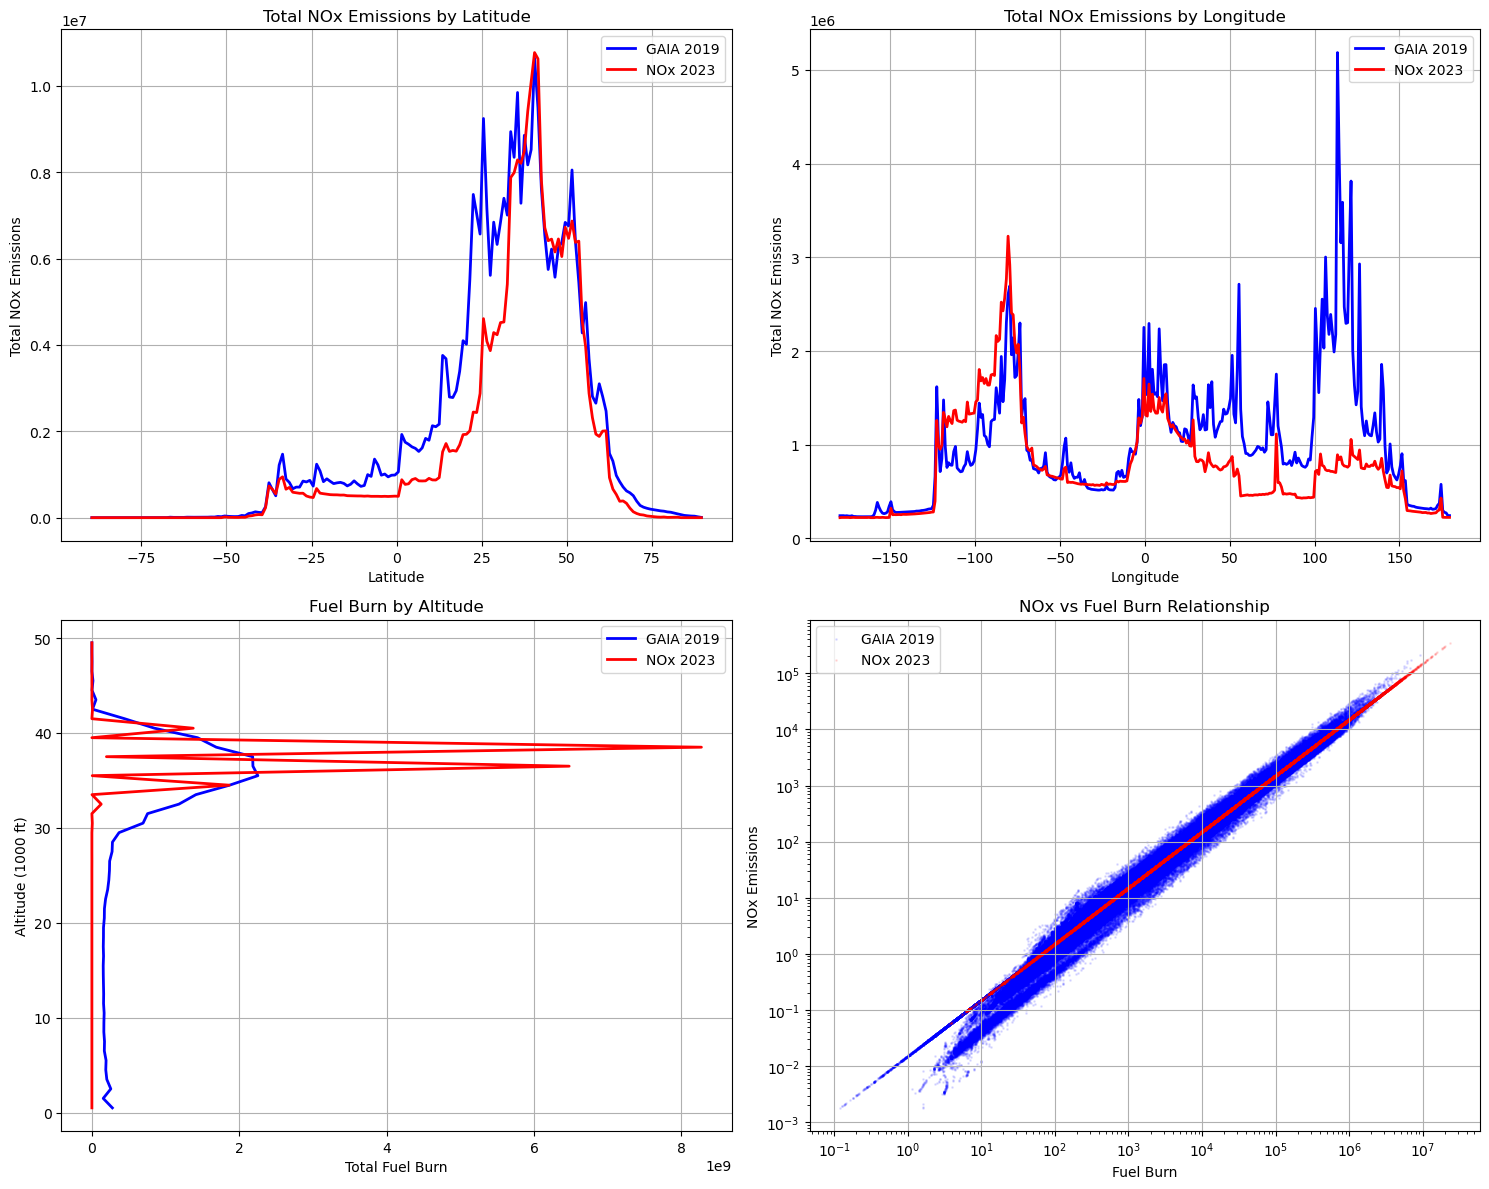

Dataset Comparison Summary:
GAIA 2019 Total NOx: 3.63e+08
NOx 2023 Total NOx: 2.78e+08
Ratio (2023/2019): 0.77

GAIA 2019 Total Fuel Burn: 2.29e+10
NOx 2023 Total Fuel Burn: 1.83e+10
Ratio (2023/2019): 0.80


In [2]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Total NOx emissions by altitude for both datasets
gaia_nox_alt = gaia.nox.sum(dim=['longitude', 'latitude', 'time'])
nox_nox_alt = nox.nox.sum(dim=['longitude', 'latitude', 'time'])

axes[0, 0].plot(gaia_nox_alt.values, gaia.altitude_ft.values/1000, 'b-', label='GAIA 2019', linewidth=2)
axes[0, 0].plot(nox_nox_alt.values, nox.altitude_ft.values/1000, 'r-', label='NOx 2023', linewidth=2)
axes[0, 0].set_xlabel('Total NOx Emissions')
axes[0, 0].set_ylabel('Altitude (1000 ft)')
axes[0, 0].set_title('NOx Emissions by Altitude')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot 2: Global surface emissions (lowest altitude)
gaia_surface = gaia.nox.isel(altitude_ft=0, time=0)
nox_surface = nox.nox.isel(altitude_ft=0, time=0)

im1 = axes[0, 1].pcolormesh(gaia.longitude, gaia.latitude, gaia_surface.T, shading='auto')
axes[0, 1].set_title('GAIA 2019 - Surface NOx Emissions')
axes[0, 1].set_xlabel('Longitude')
axes[0, 1].set_ylabel('Latitude')
plt.colorbar(im1, ax=axes[0, 1])

im2 = axes[0, 2].pcolormesh(nox.longitude, nox.latitude, nox_surface.T, shading='auto')
axes[0, 2].set_title('NOx 2023 - Surface NOx Emissions')
axes[0, 2].set_xlabel('Longitude')
axes[0, 2].set_ylabel('Latitude')
plt.colorbar(im2, ax=axes[0, 2])

# Plot 3: Cruise altitude emissions (~35,000 ft)
cruise_idx_gaia = np.argmin(np.abs(gaia.altitude_ft.values - 35000))
cruise_idx_nox = np.argmin(np.abs(nox.altitude_ft.values - 35000))

gaia_cruise = gaia.nox.isel(altitude_ft=cruise_idx_gaia, time=0)
nox_cruise = nox.nox.isel(altitude_ft=cruise_idx_nox, time=0)

im3 = axes[1, 0].pcolormesh(gaia.longitude, gaia.latitude, gaia_cruise.T, shading='auto')
axes[1, 0].set_title('GAIA 2019 - Cruise Altitude NOx (~35k ft)')
axes[1, 0].set_xlabel('Longitude')
axes[1, 0].set_ylabel('Latitude')
plt.colorbar(im3, ax=axes[1, 0])

im4 = axes[1, 1].pcolormesh(nox.longitude, nox.latitude, nox_cruise.T, shading='auto')
axes[1, 1].set_title('NOx 2023 - Cruise Altitude NOx (~35k ft)')
axes[1, 1].set_xlabel('Longitude')
axes[1, 1].set_ylabel('Latitude')
plt.colorbar(im4, ax=axes[1, 1])

# Plot 4: Ratio comparison at cruise altitude
# Add small value to avoid division by zero
ratio = nox_cruise / (gaia_cruise + 1e-15)
ratio = ratio.where(gaia_cruise > 1e-10)  # Mask where GAIA emissions are negligible

im5 = axes[1, 2].pcolormesh(nox.longitude, nox.latitude, ratio.T, shading='auto', vmin=0, vmax=5)
axes[1, 2].set_title('NOx 2023 / GAIA 2019 Ratio (Cruise Alt)')
axes[1, 2].set_xlabel('Longitude')
axes[1, 2].set_ylabel('Latitude')
plt.colorbar(im5, ax=axes[1, 2], label='Ratio')

plt.tight_layout()
plt.show()

# Additional plots for total emissions comparison
fig2, axes2 = plt.subplots(2, 2, figsize=(15, 12))

# Total emissions by latitude
gaia_lat_total = gaia.nox.sum(dim=['longitude', 'altitude_ft', 'time'])
nox_lat_total = nox.nox.sum(dim=['longitude', 'altitude_ft', 'time'])

axes2[0, 0].plot(gaia.latitude, gaia_lat_total, 'b-', label='GAIA 2019', linewidth=2)
axes2[0, 0].plot(nox.latitude, nox_lat_total, 'r-', label='NOx 2023', linewidth=2)
axes2[0, 0].set_xlabel('Latitude')
axes2[0, 0].set_ylabel('Total NOx Emissions')
axes2[0, 0].set_title('Total NOx Emissions by Latitude')
axes2[0, 0].legend()
axes2[0, 0].grid(True)

# Total emissions by longitude
gaia_lon_total = gaia.nox.sum(dim=['latitude', 'altitude_ft', 'time'])
nox_lon_total = nox.nox.sum(dim=['latitude', 'altitude_ft', 'time'])

axes2[0, 1].plot(gaia.longitude, gaia_lon_total, 'b-', label='GAIA 2019', linewidth=2)
axes2[0, 1].plot(nox.longitude, nox_lon_total, 'r-', label='NOx 2023', linewidth=2)
axes2[0, 1].set_xlabel('Longitude')
axes2[0, 1].set_ylabel('Total NOx Emissions')
axes2[0, 1].set_title('Total NOx Emissions by Longitude')
axes2[0, 1].legend()
axes2[0, 1].grid(True)

# Fuel burn comparison by altitude
gaia_fuel_alt = gaia.fuel_burn.sum(dim=['longitude', 'latitude', 'time'])
nox_fuel_alt = nox.fuel_burn.sum(dim=['longitude', 'latitude', 'time'])

axes2[1, 0].plot(gaia_fuel_alt.values, gaia.altitude_ft.values/1000, 'b-', label='GAIA 2019', linewidth=2)
axes2[1, 0].plot(nox_fuel_alt.values, nox.altitude_ft.values/1000, 'r-', label='NOx 2023', linewidth=2)
axes2[1, 0].set_xlabel('Total Fuel Burn')
axes2[1, 0].set_ylabel('Altitude (1000 ft)')
axes2[1, 0].set_title('Fuel Burn by Altitude')
axes2[1, 0].legend()
axes2[1, 0].grid(True)

# Scatter plot: NOx vs Fuel Burn
gaia_scatter = gaia.nox.values.flatten()
gaia_fuel_scatter = gaia.fuel_burn.values.flatten()
nox_scatter = nox.nox.values.flatten()
nox_fuel_scatter = nox.fuel_burn.values.flatten()

# Remove zeros for better visualization
gaia_mask = (gaia_scatter > 0) & (gaia_fuel_scatter > 0)
nox_mask = (nox_scatter > 0) & (nox_fuel_scatter > 0)

axes2[1, 1].scatter(gaia_fuel_scatter[gaia_mask], gaia_scatter[gaia_mask], 
                   alpha=0.1, s=1, c='blue', label='GAIA 2019')
axes2[1, 1].scatter(nox_fuel_scatter[nox_mask], nox_scatter[nox_mask], 
                   alpha=0.1, s=1, c='red', label='NOx 2023')
axes2[1, 1].set_xlabel('Fuel Burn')
axes2[1, 1].set_ylabel('NOx Emissions')
axes2[1, 1].set_title('NOx vs Fuel Burn Relationship')
axes2[1, 1].set_xscale('log')
axes2[1, 1].set_yscale('log')
axes2[1, 1].legend()
axes2[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Dataset Comparison Summary:")
print("=" * 50)
print(f"GAIA 2019 Total NOx: {gaia.nox.sum().values:.2e}")
print(f"NOx 2023 Total NOx: {nox.nox.sum().values:.2e}")
print(f"Ratio (2023/2019): {nox.nox.sum().values / gaia.nox.sum().values:.2f}")
print()
print(f"GAIA 2019 Total Fuel Burn: {gaia.fuel_burn.sum().values:.2e}")
print(f"NOx 2023 Total Fuel Burn: {nox.fuel_burn.sum().values:.2e}")
print(f"Ratio (2023/2019): {nox.fuel_burn.sum().values / gaia.fuel_burn.sum().values:.2f}")